# Machine Learning ALP Model

## Background
Diabetes is a significant health problem in Indonesia, affecting 19.5 million people. Projections indicate a 150% increase in cases within the next 20 years (Zuhdi, 2023). This is primarily due to a lack of awareness about the risks of high sugar intake and a carbohydrate-heavy diet. Current efforts prioritize treatment over prevention, while early risk assessment could substantially reduce the disease burden.

## Dataset
Our dataset comprises 253,680 health records from the BRFSS, including 22 features like physical activity and smoking status. This annually collected data has no missing values, requiring minimal data cleaning.

## Imports

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import graphviz 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import skl2onnx
from skl2onnx import convert
from skl2onnx.common.data_types import FloatTensorType
from sklearn.utils import resample
from scipy.stats import zscore

# Preprocessing

## Load dataset & Preview

In [2]:
url = "diabetes_012_health_indicators_BRFSS2015.csv"
data = pd.read_csv(url)
data.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

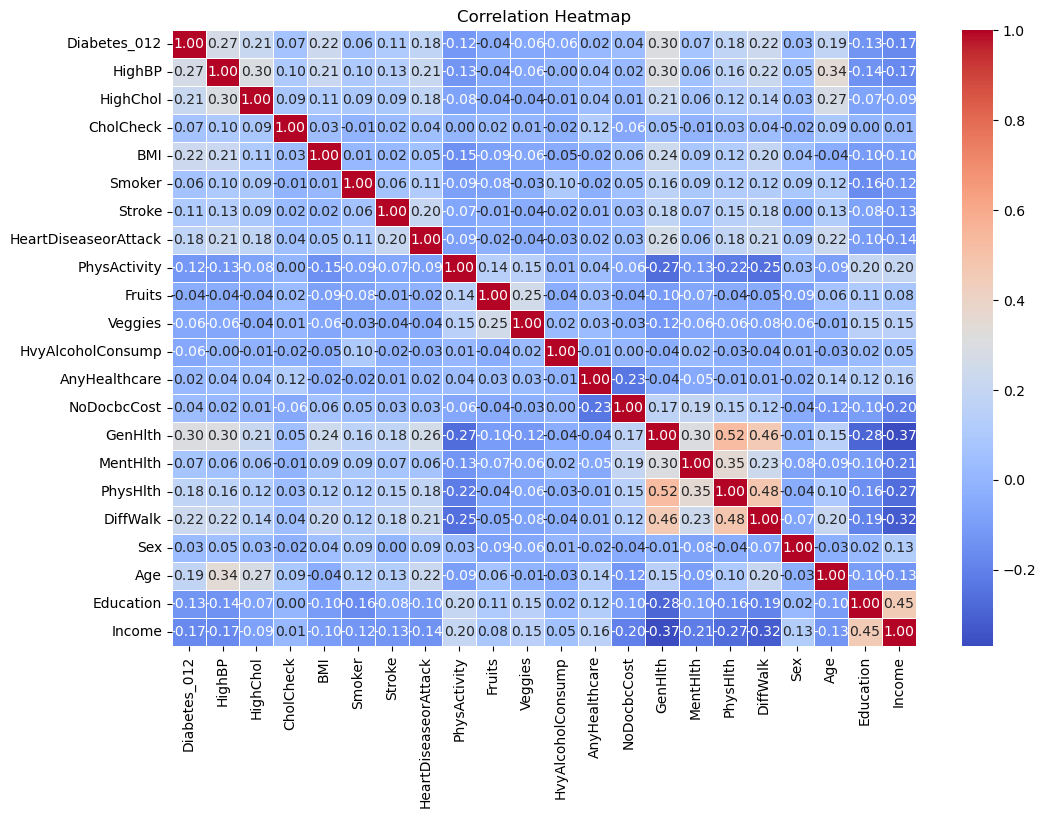

In [4]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## Data Cleaning

### Check & treat null or missing values

In [5]:
missing_values = data.isnull().sum()
missing_values

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

we found no missing values, so we dont have to treat it

### Check & treat duplicate values

In [6]:
duplicates = data.duplicated()

num_duplicates = duplicates.sum()

print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    duplicate_rows = data[duplicates]
    print("Duplicate rows:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

Number of duplicate rows: 23899
Duplicate rows:
        Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
1242             2.0     1.0       1.0        1.0  27.0     1.0     0.0   
1563             0.0     0.0       0.0        1.0  21.0     1.0     0.0   
2700             0.0     0.0       0.0        1.0  32.0     0.0     0.0   
3160             0.0     0.0       0.0        1.0  21.0     0.0     0.0   
3332             0.0     0.0       0.0        1.0  24.0     0.0     0.0   
...              ...     ...       ...        ...   ...     ...     ...   
253492           2.0     1.0       1.0        1.0  33.0     0.0     0.0   
253550           0.0     0.0       0.0        1.0  25.0     0.0     0.0   
253563           0.0     0.0       1.0        1.0  24.0     1.0     0.0   
253597           0.0     0.0       0.0        1.0  24.0     0.0     0.0   
253638           0.0     0.0       0.0        1.0  24.0     0.0     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits 

we found 23897 duplicated data, and to treat it we wont be bothering it by just dropping them, we have 200k+ samples anyways

In [7]:
data_before = data
data = data.drop_duplicates()

print(f"Number of rows before cleaning: {len(data_before)}")
print(f"Number of rows after cleaning: {len(data)}")

Number of rows before cleaning: 253680
Number of rows after cleaning: 229781


### Check & treat outliers

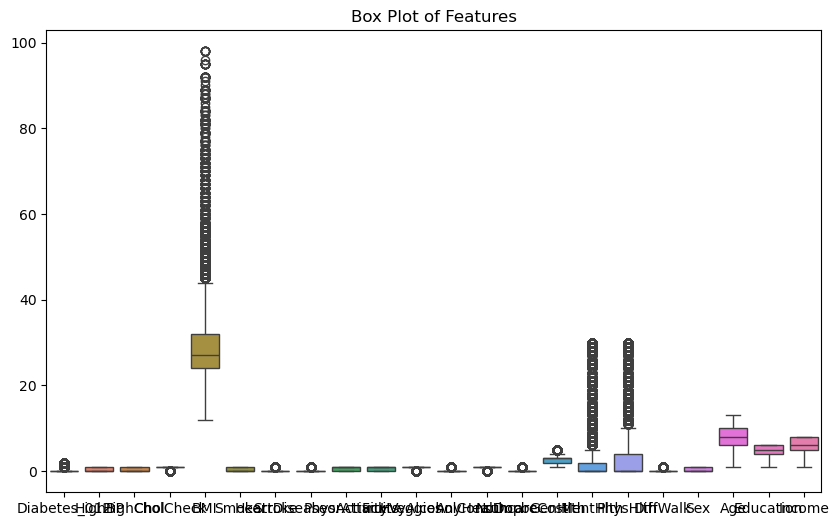

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.title("Box Plot of Features")
plt.show()

it looks like we have many outliers in the feature: bmi, mental health, and physical health

In [9]:
data_cleaned = pd.DataFrame()

# Loop through each class in the 'Diabetes' column
for cls in data['Diabetes_012'].unique():
    # Subset the data for the current class
    class_data = data[data['Diabetes_012'] == cls]

    # Calculate IQR for the current class
    Q1 = class_data.quantile(0.25)
    Q3 = class_data.quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for the current class
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter data within the bounds for the current class
    class_data_cleaned = class_data[~((class_data < lower_bound) | (class_data > upper_bound)).any(axis=1)]

    # Append the cleaned class data to the final DataFrame
    data_cleaned = pd.concat([data_cleaned, class_data_cleaned])



Original dataset shape: (229781, 22)
Cleaned dataset shape: (75446, 22)


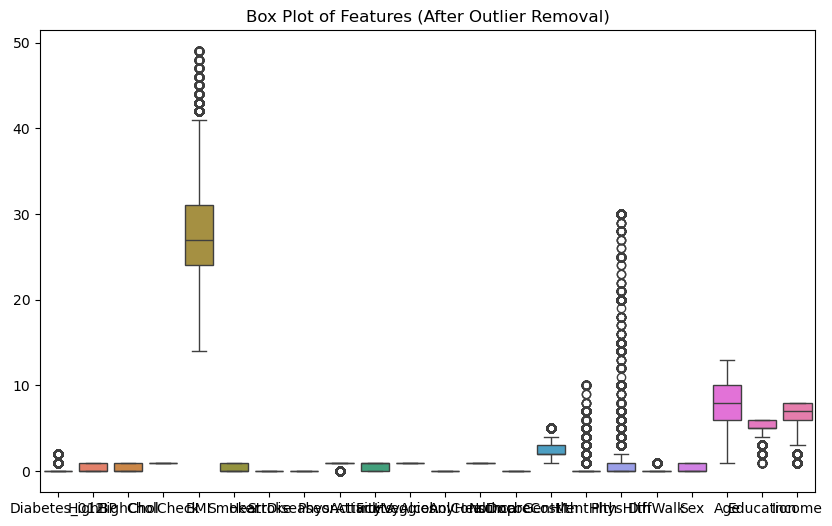

In [10]:
# data_cleaned = data

print("Original dataset shape:", data.shape)
print("Cleaned dataset shape:", data_cleaned.shape)

plt.figure(figsize=(10, 6))
sns.boxplot(data=data_cleaned)
plt.title("Box Plot of Features (After Outlier Removal)")
plt.show()

### Under Sampling

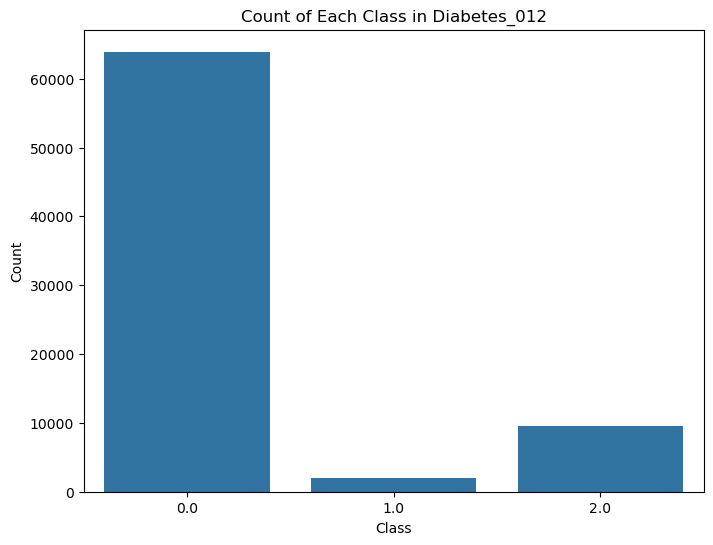

Number of rows before dropping class 1: 229781


In [11]:
# See the target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=data_cleaned['Diabetes_012'])
plt.title('Count of Each Class in Diabetes_012')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
print(f"Number of rows before dropping class 1: {len(data)}")

We want the data to be under sampled with the size of class 2, class 2 represents the person that has diabetes, class 1 represents person with pre diabetes symptoms and class 0 represents people with no diabetes.

Remove class 1 because of its insignificant

In [12]:
## Remove Class 1
data_cleaned = data_cleaned[data_cleaned['Diabetes_012'] != 1]

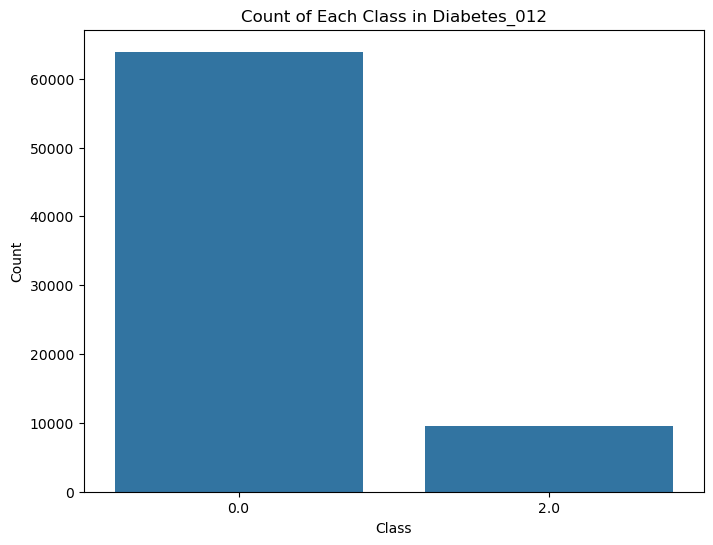

Number of rows after dropping class 1: 229781


In [13]:
# see the target distribution after dropping class 1
plt.figure(figsize=(8, 6))
sns.countplot(x=data_cleaned['Diabetes_012'])
plt.title('Count of Each Class in Diabetes_012')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
print(f"Number of rows after dropping class 1: {len(data)}")

now we can perform undersampling

In [14]:
class_0 = data_cleaned[data_cleaned['Diabetes_012'] == 0]
class_2 = data_cleaned[data_cleaned['Diabetes_012'] == 2]

class_0_undersampled = resample(class_0, replace=False, n_samples=len(class_2), random_state=0)

balanced_data = pd.concat([class_0_undersampled,class_2])

now we have to shuffle the rows to avoid ordering bias

In [15]:
balanced_data = balanced_data.sample(frac=1, random_state=0).reset_index(drop=True)

we can verify the balanced data

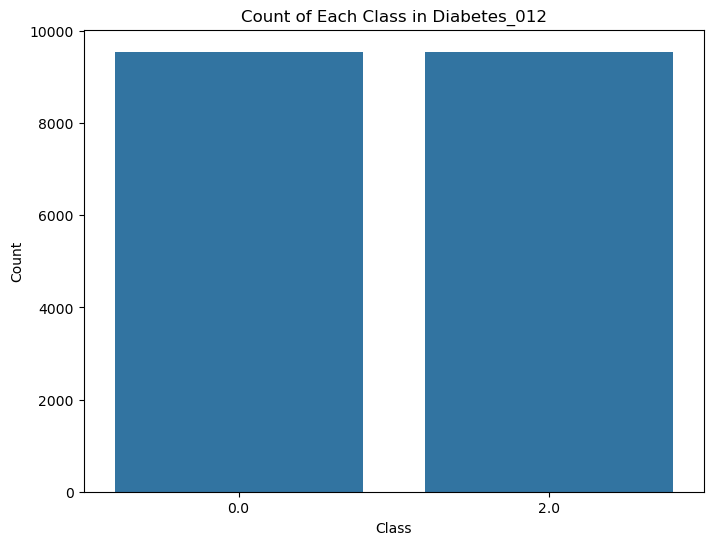

Number of rows after dropping undersampling: 19102


In [16]:
# see the target distribution after undersampling
plt.figure(figsize=(8, 6))
sns.countplot(x=balanced_data['Diabetes_012'])
plt.title('Count of Each Class in Diabetes_012')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
print(f"Number of rows after dropping undersampling: {len(balanced_data)}")

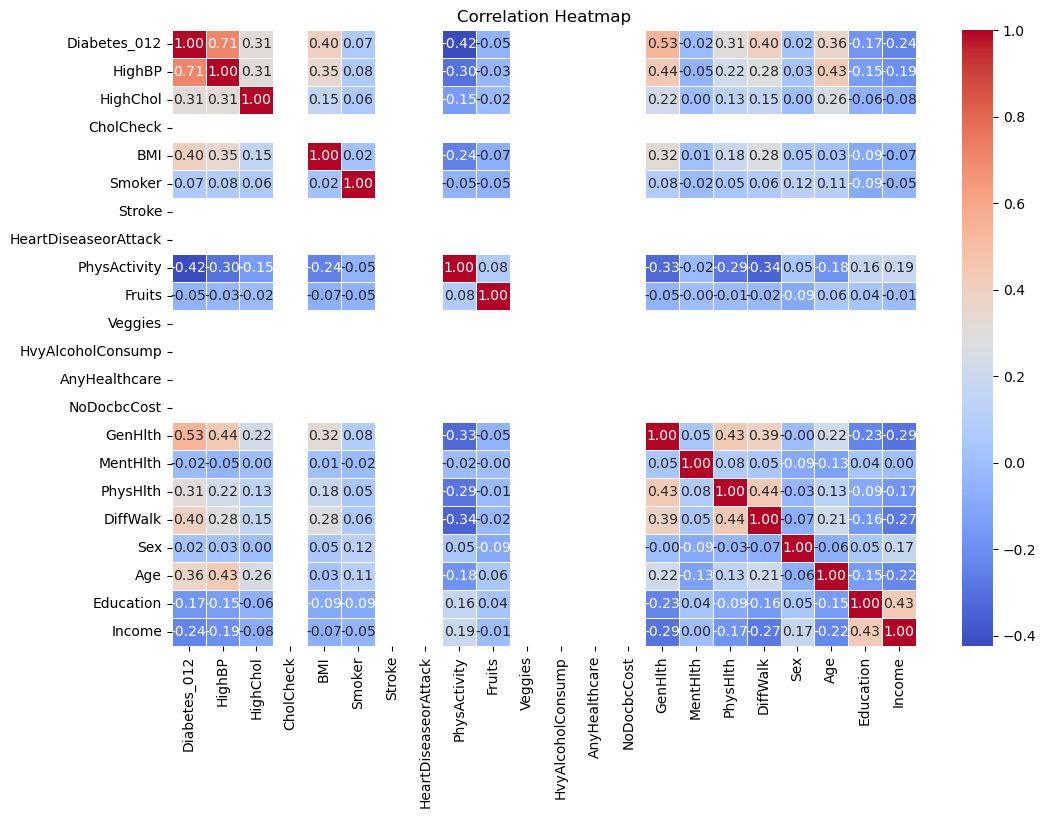

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(balanced_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### Scaling

In [18]:
# split the dataset
X = balanced_data.drop(columns=['Diabetes_012'])
y = balanced_data['Diabetes_012']

In [19]:
# Scalie the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

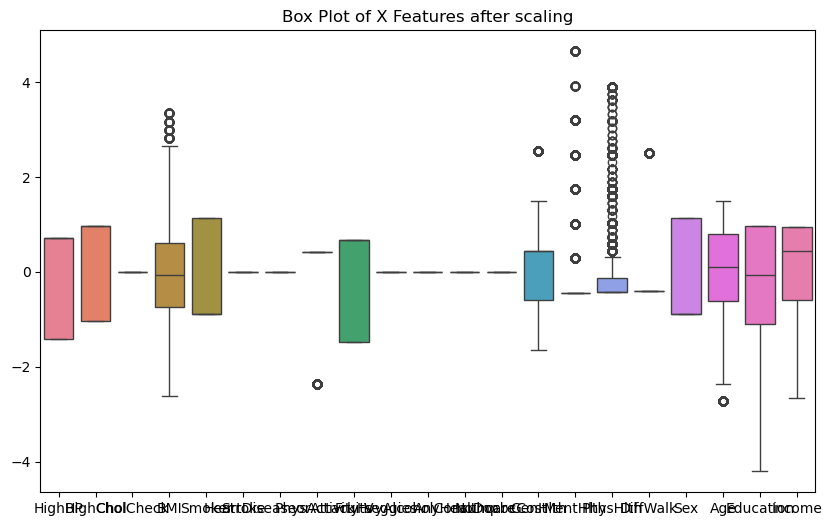

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_scaled)
plt.title("Box Plot of X Features after scaling")
plt.show()

## Model Training

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [22]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200,300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

In [23]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [24]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [25]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = grid_search.best_estimator_

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [26]:
# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")

Accuracy on Test Set: 0.8828


## Evaluation

Accuracy on Test Set: 0.8828
Confusion Matrix:
[[1525  355]
 [  93 1848]]


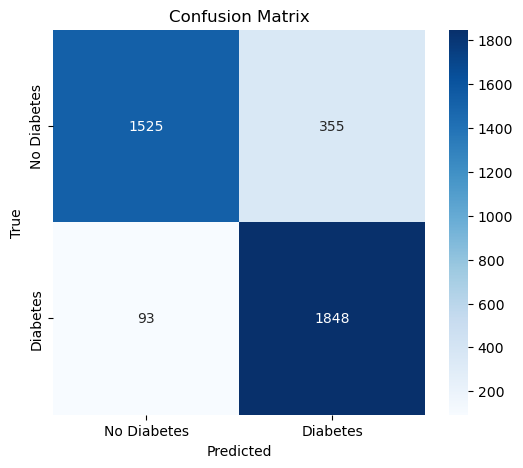

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87      1880
         2.0       0.84      0.95      0.89      1941

    accuracy                           0.88      3821
   macro avg       0.89      0.88      0.88      3821
weighted avg       0.89      0.88      0.88      3821



ValueError: y_true takes value in {0.0, 2.0} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [27]:
# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()